# Fruits and Vegetables Classifier

### Import Libraries and Data Directories

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense,Dropout,Flatten,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random, pathlib
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Assign directory with training data
train_dir = os.path.join('new_dataset/train-70')

# Directory with testing data
test_dir = os.path.join('new_dataset/test-20')

# Validation directory
validation_dir = os.path.join('new_dataset/validation-10')

print('Training set classes:', len(os.listdir(train_dir)))
print('Testing set size:', len(os.listdir(test_dir)))
print('Validation set size:', len(os.listdir(validation_dir)))

Training set classes: 39
Testing set size: 39
Validation set size: 39


### Transfer learning using InceptionV3 model

In [3]:
# Instantiate the pre-trained model

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150,150,3), #desired input shape for our data
                               include_top = False, #we want to ignore the fully-connected layer at the top, and jump right into the convolutional layers
                               weights = None) #specify we don't want to use the built-in weights but the snapshot we just downloaded

pre_trained_model.load_weights(local_weights_file)

In [4]:
# Iterate through it's layers and lock them

for layer in pre_trained_model.layers:
    layer.trainable = False #so they  will not be trainable with this code
    
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

### Building the new model

In [5]:
# Try using 7x7 layers instead of 3x3 for comparison with clean training

last_layer =  pre_trained_model.get_layer('mixed7')

last_output = last_layer.output

In [8]:
# Then we can define our model, taking the  output from the inception model's mixed7 layer, which we had called as the last output

x = layers.MaxPooling2D()(last_output) # Decrease trainable params for smaller file size
x = layers.Flatten()(x) #flatten the output, which is the last output from the inception
x = layers.Dense(512, activation='relu')(x) 
x = Dropout(0.2)(x)
x = layers.Dense(39, activation='softmax')(x) #prediction

model = Model(pre_trained_model.input, x) #model = Model(inputs=inception.input,outputs=prediction)
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

### Model Training

#### Training Setup

In [10]:
# Data Processing

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image augmentation
train_datagen = ImageDataGenerator(rescale = 1/255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1/255)

print('Training set:')
# Train set - Flow training images in batches of 64 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 32,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150)
                                                   )

print('\nTesting set:')
# Test set - Flow validation images in batches of 64 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size = 32,
                                                         class_mode = 'categorical',
                                                         target_size = (150,150)
                                                        )

print('\nValidation set:')
# Classes to validation set
validation_datagen = ImageDataGenerator( rescale = 1/255)
validation_set = validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size = 32,
                                                         class_mode = 'categorical',
                                                         target_size = (150,150)
                                                        )

Training set:
Found 31887 images belonging to 39 classes.

Testing set:
Found 9112 images belonging to 39 classes.

Validation set:
Found 4551 images belonging to 39 classes.


In [11]:
# Callback to stop the training when targeted accuracy value is met

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=3, 
                                              mode='min', 
                                              verbose=1)
checkpoint = ModelCheckpoint('best_model_v6.h5', 
                             monitor='val_loss',
                             mode='min', 
                             verbose=1, 
                             save_best_only=True)

In [12]:
steps = train_generator.samples//train_generator.batch_size+1
print('Steps per epoch:',steps)
valid_steps = validation_generator.samples//validation_generator.batch_size+1
print('Validation steps:',valid_steps)

Steps per epoch: 997
Validation steps: 285


#### Training

In [13]:
history = model.fit_generator(train_generator,
                              validation_data = validation_generator,
                              epochs = 100,
                              steps_per_epoch = steps,
                              validation_steps = valid_steps,
                              verbose = 1,
                              callbacks = [early_stop, checkpoint]
                             )

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_24412/163105140.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/100
997/997 [==============================] - ETA: 0s - loss: 1.1755 - accuracy: 0.6723
Epoch 1: val_loss improved from inf to 0.59903, saving model to best_model_v6.h5
997/997 [==============================] - 331s 330ms/step - loss: 1.1755 - accuracy: 0.6723 - val_loss: 0.5990 - val_accuracy: 0.8178
Epoch 2/100
997/997 [==============================] - ETA: 0s - loss: 0.7759 - accuracy: 0.7684
Epoch 2: val_loss improved from 0.59903 to 0.53579, saving model to best_model_v6.h5
997/997 [==============================] - 322s 323ms/step - loss: 0.7759 - accuracy: 0.7684 - val_loss: 0.5358 - val_accuracy: 0.8380
Epoch 3/100
997/997 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.7922
Epoch 3: val_loss improved from 0.53579 to 0.52748, saving model to best_model_v6.h5
997/997 [==============================] - 334s 335ms/step - loss: 0.6974 - accuracy: 0.7922 - val_loss: 0.5275 - val_accuracy: 0.8377
Epoch 4/100
997/997 [==============================] 

In [15]:
# Save history of model

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'v6_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'v6_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

#### Training Evaluation

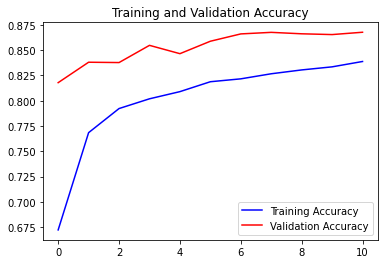

<Figure size 432x288 with 0 Axes>

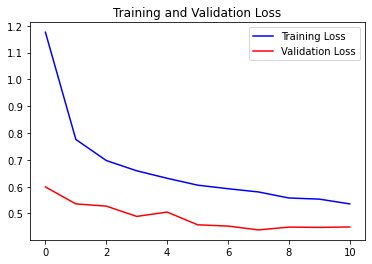

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()
plt.savefig('v6_accuracy.png')

plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()
plt.savefig('v6_loss.png')

### Model Evaluation

#### Load Trained Model

In [4]:
model = load_model('best_model_v6.h5')

In [5]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

#### Predict against Validation Set

In [6]:
# Using the validation dataset

validation_dir = os.path.join('new_dataset/validation-10')

evaluation_datagen = image.ImageDataGenerator( rescale = 1/255)
evaluation_generator = evaluation_datagen.flow_from_directory(validation_dir,
                                                              class_mode = 'categorical',
                                                              target_size = (150,150),
                                                              shuffle=False
                                                              )

scores = model.evaluate_generator(evaluation_generator, verbose=1)

print('Model Accuracy on Validation Dataset: {:.4f}'.format(scores[1]))
print('Model Loss on Validation Dataset: {:.4f}'.format(scores[0]))

Found 4551 images belonging to 39 classes.


C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_15760/2172225774.py:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(evaluation_generator, verbose=1)


143/143 [==============================] - 25s 173ms/step - loss: 0.4238 - accuracy: 0.8783
Model Accuracy on Validation Dataset: 0.8783
Model Loss on Validation Dataset: 0.4238


#### Confusion Matrix and Classification Report

In [7]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('v6_confusion_matrix.png')

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_24412/2418394084.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(evaluation_generator)#, nb_test_samples // BATCH_SIZE, workers=1)


Classification Report
               precision    recall  f1-score   support

        Apple       0.75      0.63      0.68       120
      Avocado       0.83      0.87      0.85       117
       Banana       1.00      0.93      0.96       117
         Bean       0.98      0.98      0.98       140
 Bitter Gourd       0.99      1.00      1.00       140
    Blueberry       0.72      0.97      0.83       100
 Bottle Gourd       0.99      0.97      0.98       140
      Brinjal       0.98      1.00      0.99       140
     Broccoli       0.99      0.99      0.99       140
      Cabbage       0.99      1.00      1.00       140
     Capsicum       0.99      0.99      0.99       140
       Carrot       0.99      1.00      1.00       140
  Cauliflower       1.00      0.99      1.00       140
      Coconut       0.88      0.70      0.78       102
     Cucumber       0.97      1.00      0.99       140
  Dragonfruit       0.96      0.87      0.91       103
       Durian       0.94      0.99      0.

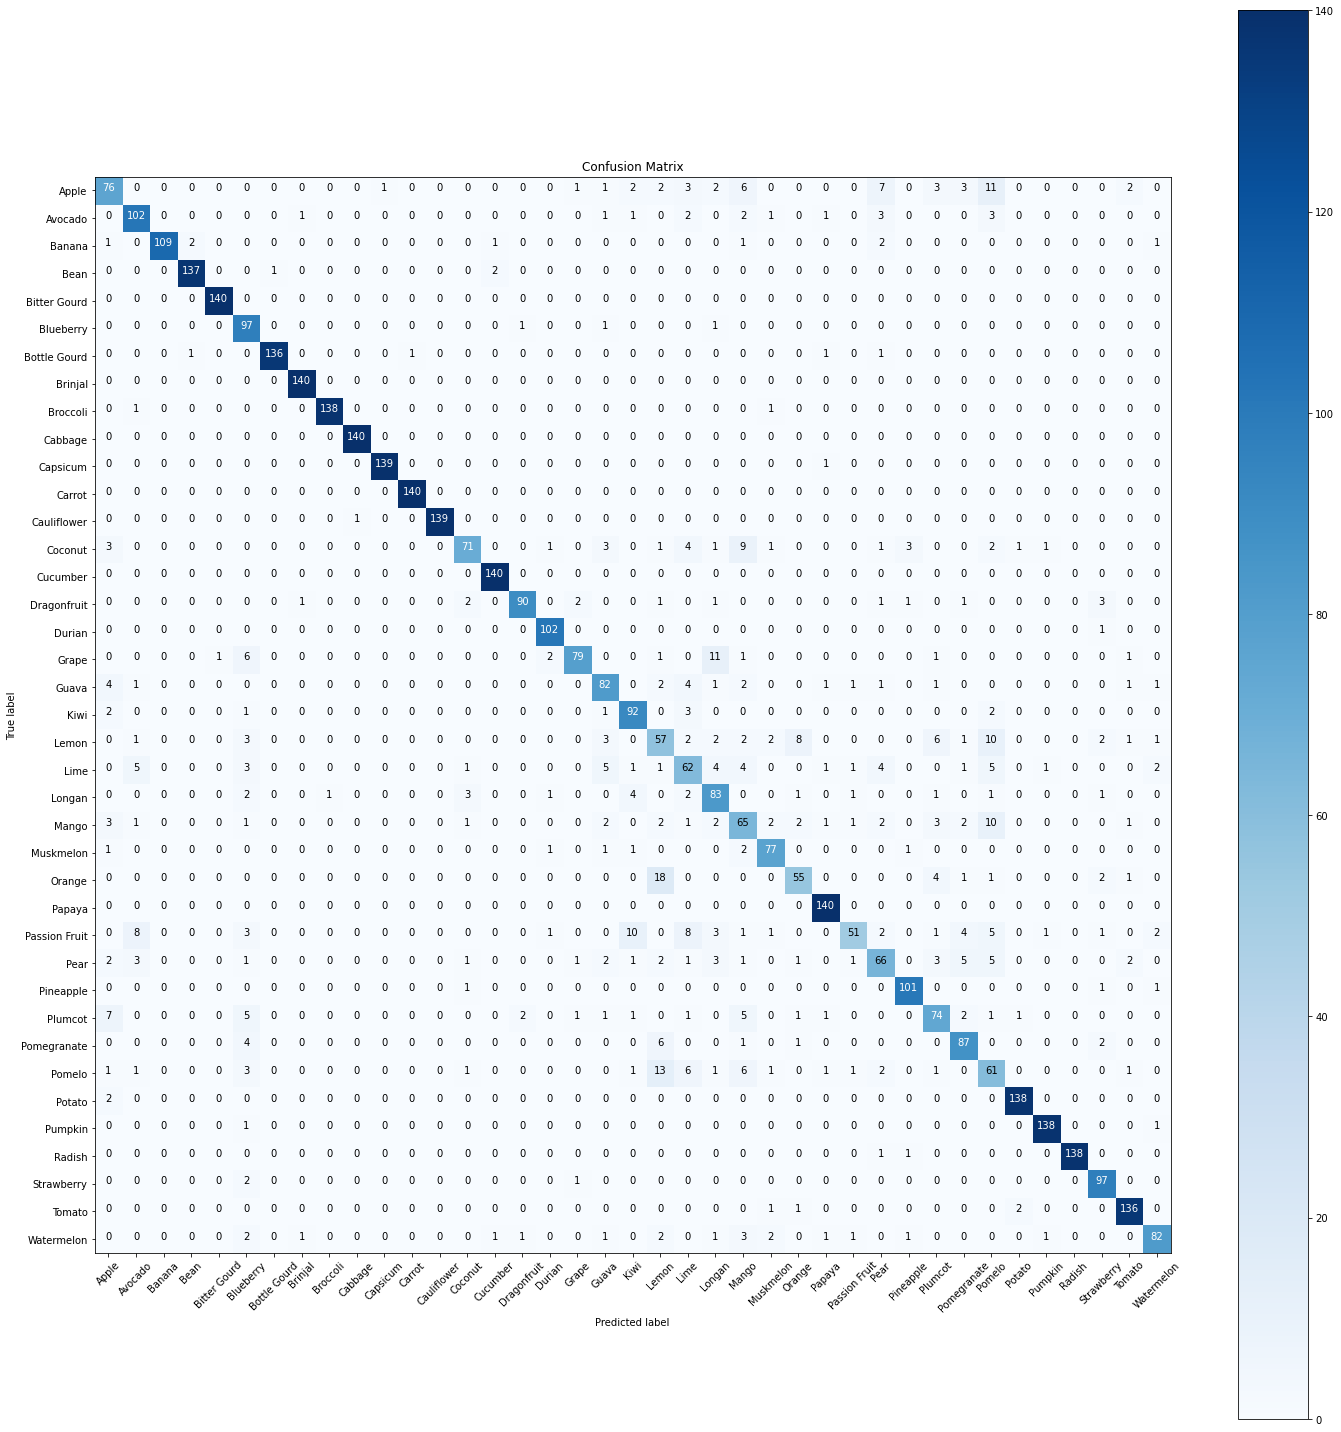

In [25]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

classes = list(evaluation_generator.class_indices.keys())

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(evaluation_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(evaluation_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
report = classification_report(evaluation_generator.classes, y_pred, target_names=target_names) # output_dict=True only for saving csv file
print(report)

In [ ]:
# Save classification report to csv file

df = pd.DataFrame(report).transpose()
df.to_csv('v6_classification_report.csv')

#### View Individual Results for further Evaluation

In [49]:
category={
    0: 'Apple', 1: 'Avocado', 2: 'Banana', 3: 'Bean', 4: 'Bitter Gourd', 5: 'Blueberry', 
    6: 'Bottle Gourd', 7: 'Brinjal', 8: 'Broccoli', 9: 'Cabbage', 10: 'Capsicum', 11: 'Carrot', 
    12: 'Cauliflower', 13: 'Coconut', 14: 'Cucumber', 15: 'Dragonfruit', 16: 'Durian', 17: 'Grape', 
    18: 'Guava', 19: 'Kiwi', 20: 'Lemon', 21: 'Lime', 22: 'Longan', 23: 'Mango', 
    24: 'Muskmelon', 25: 'Orange', 26: 'Papaya', 27: 'Passion Fruit', 28: 'Pear', 29: 'Pineapple', 
    30: 'Plumcot', 31: 'Pomegranate', 32: 'Pomelo', 33: 'Potato', 34: 'Pumpkin', 35: 'Radish', 
    36: 'Strawberry', 37: 'Tomato', 38: 'Watermelon'
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(150, 150))
    img_array = image.img_to_array(img_)
    x = np.expand_dims(img_array, axis=0) 
    x /= 255.   
    
    prediction = model.predict(x)
    index = np.argmax(prediction)
    
    plt.title("Predicted Class : {}".format(category[index]), fontdict = {'fontsize' : 14,'color': 'red'})
    plt.axis('off')
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(150, 150))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

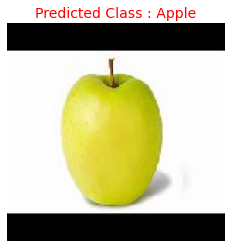

In [16]:
predict_image(os.path.join('new_dataset/validation-10/Apple/1100.jpg'),model)

In [10]:
for fn in os.listdir('new_dataset/validation-10/'):
    predict_dir(os.path.join('new_dataset/validation-10/', fn),model)

Accuracy for Apple: 0.63 (76/120)
Accuracy for Avocado: 0.87 (102/117)
Accuracy for Banana: 0.93 (109/117)
Accuracy for Bean: 0.98 (137/140)
Accuracy for Bitter Gourd: 1.00 (140/140)
Accuracy for Blueberry: 0.97 (97/100)
Accuracy for Bottle Gourd: 0.97 (136/140)
Accuracy for Brinjal: 1.00 (140/140)
Accuracy for Broccoli: 0.99 (138/140)
Accuracy for Cabbage: 1.00 (140/140)
Accuracy for Capsicum: 0.99 (139/140)
Accuracy for Carrot: 1.00 (140/140)
Accuracy for Cauliflower: 0.99 (139/140)
Accuracy for Coconut: 0.70 (71/102)
Accuracy for Cucumber: 1.00 (140/140)
Accuracy for Dragonfruit: 0.87 (90/103)
Accuracy for Durian: 0.99 (102/103)
Accuracy for Grape: 0.77 (79/103)
Accuracy for Guava: 0.80 (82/102)
Accuracy for Kiwi: 0.91 (92/101)
Accuracy for Lemon: 0.56 (57/101)
Accuracy for Lime: 0.61 (62/101)
Accuracy for Longan: 0.82 (83/101)
Accuracy for Mango: 0.64 (65/102)
Accuracy for Muskmelon: 0.92 (77/84)
Accuracy for Orange: 0.67 (55/82)
Accuracy for Papaya: 1.00 (140/140)
Accuracy for Pas

In [11]:
class_labels = evaluation_generator.class_indices
classnames = {e: t for t, e in class_labels.items()}
print(classnames)

{0: 'Apple', 1: 'Avocado', 2: 'Banana', 3: 'Bean', 4: 'Bitter Gourd', 5: 'Blueberry', 6: 'Bottle Gourd', 7: 'Brinjal', 8: 'Broccoli', 9: 'Cabbage', 10: 'Capsicum', 11: 'Carrot', 12: 'Cauliflower', 13: 'Coconut', 14: 'Cucumber', 15: 'Dragonfruit', 16: 'Durian', 17: 'Grape', 18: 'Guava', 19: 'Kiwi', 20: 'Lemon', 21: 'Lime', 22: 'Longan', 23: 'Mango', 24: 'Muskmelon', 25: 'Orange', 26: 'Papaya', 27: 'Passion Fruit', 28: 'Pear', 29: 'Pineapple', 30: 'Plumcot', 31: 'Pomegranate', 32: 'Pomelo', 33: 'Potato', 34: 'Pumpkin', 35: 'Radish', 36: 'Strawberry', 37: 'Tomato', 38: 'Watermelon'}


In [12]:
testpath = 'new_dataset/validation-10/'

foldernames = os.listdir(testpath)

counter_right, counter_wrong, counter_unsure = 0,0,0

for foldername in foldernames:
  # print(len(os.listdir(testpath + foldername)), foldername)
  for filename in os.listdir(testpath + foldername):
    get_any_right = 0

    img_ = image.load_img(testpath + foldername + '/' + filename, target_size=(150, 150))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    images = np.vstack([img_processed])
    classes = model.predict(images)
    
    index = np.argmax(classes[0])
    value = classes[0][index]
    
    print(f"{filename:<17} {foldername:>17} : {classnames[index]:<17} {value:>10.10f} ", end='') # {index:>3} 
    if (value<0.9):
        counter_unsure += 1

    if (foldername==classnames[index]):
        counter_right += 1
        get_any_right = 1
        print()
    else:
        counter_wrong += 1
        print("  WRONG")


print(f"Final Score: right {counter_right} : wrong {counter_wrong} : unsure {counter_unsure}, accuracy {counter_right/(counter_right+counter_wrong)}")

1083.jpg                      Apple : Apple             0.4791168571 
1084.jpg                      Apple : Apple             0.9999855757 
1085.jpg                      Apple : Apple             0.9999989271 
1086.jpg                      Apple : Apple             0.9215751886 
1087.jpg                      Apple : Pomelo            0.5768018961   WRONG
1088.jpg                      Apple : Pomelo            0.7670288086   WRONG
1089.jpg                      Apple : Apple             0.9971672893 
1090.jpg                      Apple : Apple             1.0000000000 
1091.jpg                      Apple : Apple             0.9999955893 
1092.jpg                      Apple : Apple             0.9991195798 
1093.jpg                      Apple : Apple             0.9929075241 
1094.jpg                      Apple : Apple             0.9999538660 
1095.jpg                      Apple : Apple             0.9999996424 
1096.jpg                      Apple : Apple             0.9102553129 
1097.j

##### Misclassifications : Oranges to Lemon

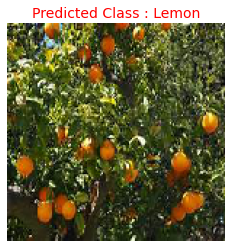

In [17]:
predict_image(os.path.join('new_dataset/validation-10/Orange/739.jpg'),model)

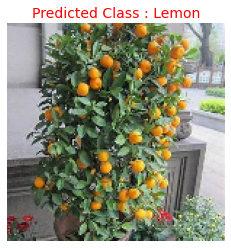

In [18]:
predict_image(os.path.join('new_dataset/validation-10/Orange/740.jpg'),model)

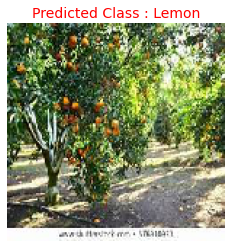

In [19]:
predict_image(os.path.join('new_dataset/validation-10/Orange/744.jpg'),model)

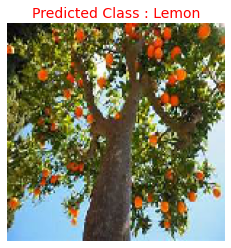

In [20]:
predict_image(os.path.join('new_dataset/validation-10/Orange/746.jpg'),model)

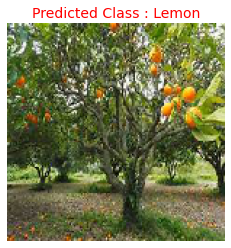

In [21]:
predict_image(os.path.join('new_dataset/validation-10/Orange/747.jpg'),model)

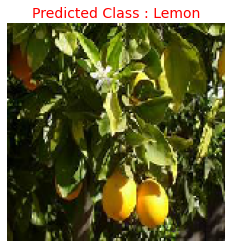

In [22]:
predict_image(os.path.join('new_dataset/validation-10/Orange/749.jpg'),model)

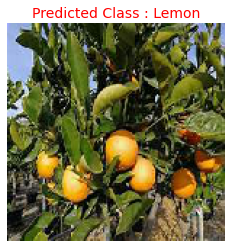

In [23]:
predict_image(os.path.join('new_dataset/validation-10/Orange/753.jpg'),model)

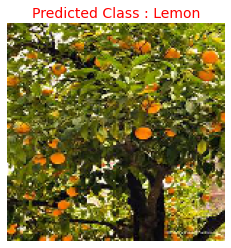

In [24]:
predict_image(os.path.join('new_dataset/validation-10/Orange/759.jpg'),model)

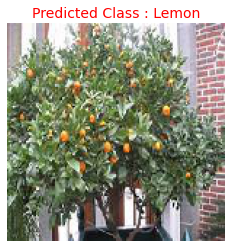

In [26]:
predict_image(os.path.join('new_dataset/validation-10/Orange/768.jpg'),model)

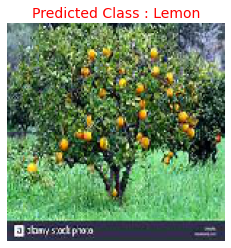

In [27]:
predict_image(os.path.join('new_dataset/validation-10/Orange/769.jpg'),model)

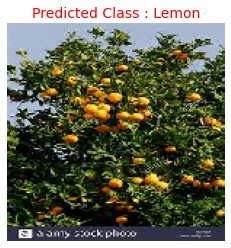

In [28]:
predict_image(os.path.join('new_dataset/validation-10/Orange/772.jpg'),model)

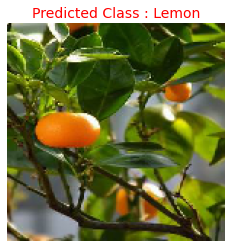

In [29]:
predict_image(os.path.join('new_dataset/validation-10/Orange/775.jpg'),model)

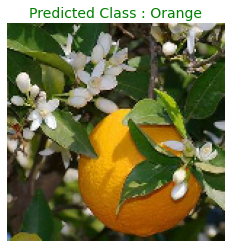

In [35]:
predict_image(os.path.join('new_dataset/validation-10/Orange/741.jpg'),model)

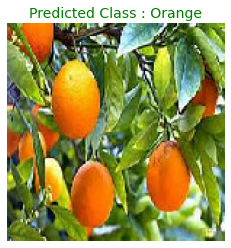

In [36]:
predict_image(os.path.join('new_dataset/validation-10/Orange/743.jpg'),model)

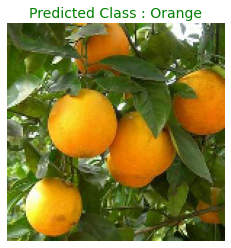

In [37]:
predict_image(os.path.join('new_dataset/validation-10/Orange/745.jpg'),model)

##### Misclassifications : Pomelo and Lemons

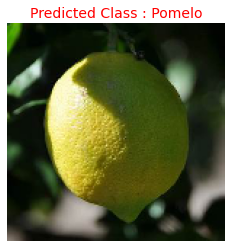

In [50]:
predict_image(os.path.join('new_dataset/validation-10/Lemon/1001.jpg'),model)

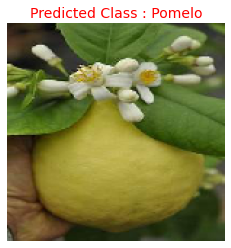

In [51]:
predict_image(os.path.join('new_dataset/validation-10/Lemon/913.jpg'),model)

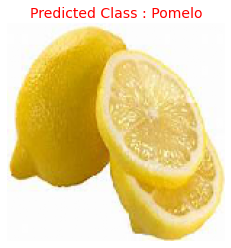

In [52]:
predict_image(os.path.join('new_dataset/validation-10/Lemon/916.jpg'),model)

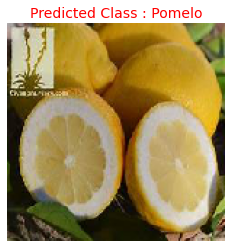

In [53]:
predict_image(os.path.join('new_dataset/validation-10/Lemon/918.jpg'),model)

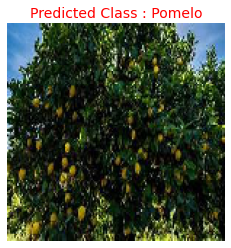

In [54]:
predict_image(os.path.join('new_dataset/validation-10/Lemon/926.jpg'),model)

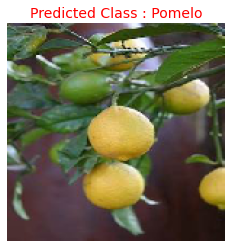

In [55]:
predict_image(os.path.join('new_dataset/validation-10/Lemon/929.jpg'),model)

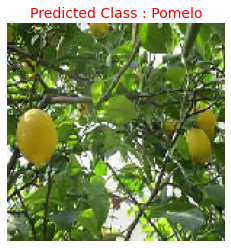

In [56]:
predict_image(os.path.join('new_dataset/validation-10/Lemon/936.jpg'),model)

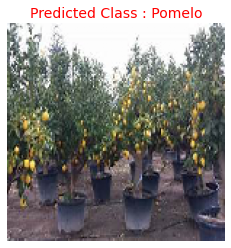

In [58]:
predict_image(os.path.join('new_dataset/validation-10/Lemon/953.jpg'),model)

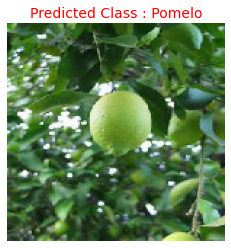

In [59]:
predict_image(os.path.join('new_dataset/validation-10/Lemon/970.jpg'),model)

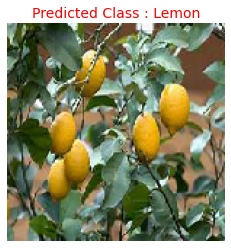

In [65]:
predict_image(os.path.join('new_dataset/validation-10/Lemon/930.jpg'),model)

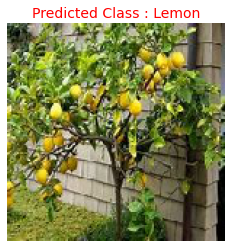

In [89]:
predict_image(os.path.join('new_dataset/train-70/Lemon/58.jpg'),model)

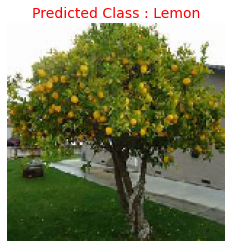

In [90]:
predict_image(os.path.join('new_dataset/train-70/Lemon/185.jpg'),model)

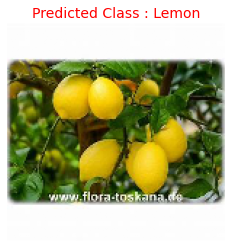

In [71]:
predict_image(os.path.join('new_dataset/validation-10/Lemon/935.jpg'),model)

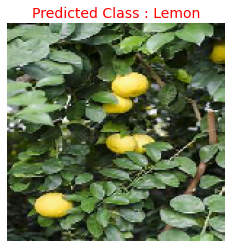

In [86]:
predict_image(os.path.join('new_dataset/validation-10/Pomelo/997.jpg'),model)

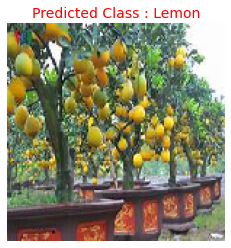

In [74]:
predict_image(os.path.join('new_dataset/validation-10/Pomelo/916.jpg'),model)

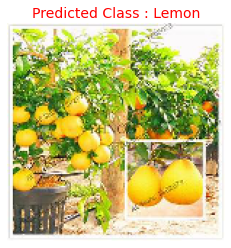

In [75]:
predict_image(os.path.join('new_dataset/validation-10/Pomelo/917.jpg'),model)

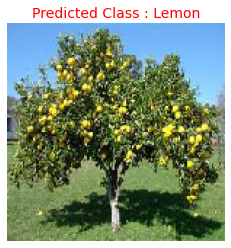

In [81]:
predict_image(os.path.join('new_dataset/validation-10/Pomelo/965.jpg'),model)

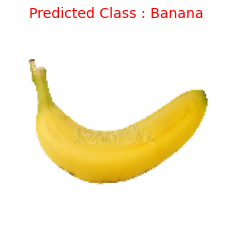

In [93]:
predict_image(os.path.join('test/banana.jpg'),model)